# Introduction
This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$

where we use the following notation:

$x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
$\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
$\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
$q > 0$ controls the risk appetite of the decision maker,
and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.
We assume the following simplifications:

all assets have the same price (normalized to 1),
the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.
The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to the optimal solution.

In [1]:
from qiskit import *
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms.minimum_eigen_solvers.qaoa.var_form import QAOAVarForm
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix
from qiskit.quantum_info import Pauli
from qiskit.aqua import aqua_globals
import pandas as pd
import quandl

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}

In [3]:
quandl.ApiConfig.api_key = "n4qQPMxtozM5Ts6iqy4w"
from qiskit import IBMQ
provider = IBMQ.load_account()

In [4]:
start_date=pd.to_datetime("2013-01-01")
end_date=pd.to_datetime("2020-06-01")

In [5]:
aapl_stk=quandl.get("WIKI/AAPL.11",start_date=start_date,end_date=end_date)
mic_stk=quandl.get("WIKI/MSFT",start_date=start_date,end_date=end_date)
ibm_stk=quandl.get("WIKI/IBM.11",start_date=start_date,end_date=end_date)
amzn_stk=quandl.get("WIKI/AMZN.11",start_date=start_date,end_date=end_date)
google_stk=quandl.get("WIKI/GOOGL",start_date=start_date,end_date=end_date)
mos_stk=quandl.get("WIKI/MOS",start_date=start_date,end_date=end_date)

In [6]:
aapl_stk.to_csv("APL")
mic_stk.to_csv("MIC")
ibm_stk.to_csv("IBM")
amzn_stk.to_csv("AMZ")
google_stk.to_csv("GOG")
mos_stk.to_csv("MOS")

In [7]:
aapl=pd.read_csv("APL", index_col="Date", parse_dates=True)
mic=pd.read_csv("MIC",index_col="Date", parse_dates=True)
ibm=pd.read_csv("IBM",index_col="Date", parse_dates=True)
amzn=pd.read_csv("AMZ",index_col="Date", parse_dates=True)
google=pd.read_csv("GOG",index_col="Date", parse_dates=True)
mos=pd.read_csv("MOS",index_col="Date", parse_dates=True)

In [8]:
data=pd.concat([aapl["Adj. Close"],mic["Adj. Close"],ibm["Adj. Close"],amzn["Adj. Close"],google["Adj. Close"],mos["Adj. Close"]],axis=1)
data.columns=["Apple", "Microsoft", "IBM", "Amazon", "Google","Mosaic"]

In [9]:
data.loc["2017-08-07"]["Apple"]=(data.loc["2017-09-07"]["Apple"]+data.loc["2017-07-07"]["Apple"])/2
data.loc["2017-08-07"]["Amazon"]=(data.loc["2017-09-07"]["Amazon"]+data.loc["2017-07-07"]["Amazon"])/2

In [10]:
data.to_csv("mos_comp_port")

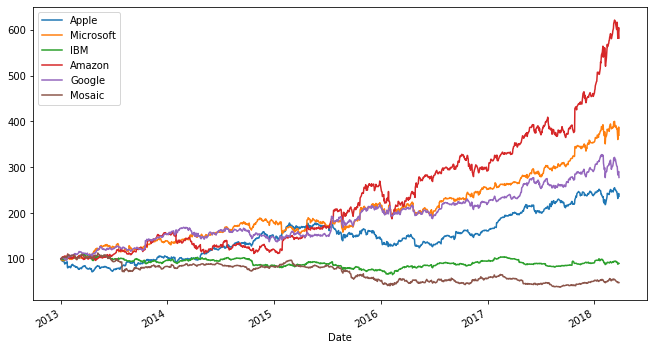

In [11]:
(data/data.iloc[0]*100).plot(figsize=(11,6))

In [12]:
log_returns=np.log(data/data.shift(1))
l_mean=np.array(log_returns.mean())
l_cov=np.array(log_returns.cov())

In [13]:
q=0.5
budget=3
penalty=1
num_assets=6

In [14]:
H, offset = portfolio.get_operator(l_mean, l_cov, q, budget, penalty)

# Optimal Solution Classically

In [15]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, l_mean, l_cov, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
        
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, l_mean, l_cov, q, budget, penalty)    
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [16]:
exact_eigensolver = NumPyMinimumEigensolver(H)
result = exact_eigensolver.run()
print_result(result)

Optimal: selection [0 1 0 1 1 0], value -0.0024

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 1 0]	-0.0024		1.0000
[1 1 1 1 1 1]	8.9987		0.0000
[0 1 1 1 1 1]	3.9989		0.0000
[1 0 1 1 1 0]	0.9982		0.0000
[0 0 1 1 1 0]	-0.0014		0.0000
[1 1 0 1 1 0]	0.9973		0.0000
[1 0 0 1 1 0]	-0.0021		0.0000
[0 0 0 1 1 0]	0.9983		0.0000
[1 1 1 0 1 0]	0.9985		0.0000
[0 1 1 0 1 0]	-0.0012		0.0000
[1 0 1 0 1 0]	-0.0009		0.0000
[0 0 1 0 1 0]	0.9995		0.0000
[1 1 0 0 1 0]	-0.0018		0.0000
[0 1 0 0 1 0]	0.9985		0.0000
[1 0 0 0 1 0]	0.9989		0.0000
[0 0 0 0 1 0]	3.9993		0.0000
[1 1 1 1 0 0]	0.9980		0.0000
[0 1 1 1 0 0]	-0.0017		0.0000
[1 0 1 1 0 0]	-0.0014		0.0000
[0 0 1 1 0 0]	0.9990		0.0000
[1 1 0 1 0 0]	-0.0023		0.0000
[0 1 0 1 0 0]	0.9980		0.0000
[1 0 0 1 0 0]	0.9984		0.0000
[0 0 0 1 0 0]	3.9988		0.0000
[1 1 1 0 0 0]	-0.0011		0.0000
[0 1 1 0 0 0]	0.9993		0.0000
[1 0 1 0 0 0]	0.9997		0.0000
[0 0 1 0 0 0]	4.0002		0.0

In [17]:
optimal_value=result.eigenvalue+offset
print('optimal_value = %.4f' % optimal_value)

optimal_value = -0.0024


/home/rafael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


# Variational Quantum Optimization - CVar-QAOA

In [18]:
# set classical optimizer
seed=50
maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

# set variational ansatz
p=4
var_form = QAOAVarForm(H,p)  # use this ansatz for CVaR-QAOA
m = var_form.num_parameters

# set backend
backend = Aer.get_backend('statevector_simulator')
Shots=8000

In [19]:
def compute_cvar(probabilities, values, alpha):
    """ 
    Auxilliary method to computes CVaR for given probabilities, values, and confidence level.
    
    Attributes:
    - probabilities: list/array of probabilities
    - values: list/array of corresponding values
    - alpha: confidence level
    
    Returns:
    - CVaR
    """
    sorted_indices = np.argsort(values)
    probs = np.array(probabilities)[sorted_indices]
    vals = np.array(values)[sorted_indices]
    cvar = 0
    total_prob = 0
    for i, (p, v) in enumerate(zip(probs, vals)):
        done = False
        if p >= alpha - total_prob:
            p = alpha - total_prob
            done = True
        total_prob += p
        cvar += p * v
    cvar /= total_prob
    return cvar

In [20]:
def eval_bitstring(H, x):
    """
    Auxilliary method to evaluate the objective function for a given bitstring
    
    Attributes:
    - H: cost Hamiltonian
    - x: bitstring
    
    Returns:
    - objective value
    """

    # invert bitstring for convenience and translate to +/-1
    x = x[::-1]    
    spins = np.array([(-1)**(b == '1') for b in x])
    value = 0
    
    # loop over pauli terms and add contribution to objective
    for p in H.paulis:
        weight = np.real(p[0])
        indices = np.where(p[1].z)
        value += weight * np.prod(spins[indices])
    return value

In [21]:
def circuit(var_form, parameters, m, q=None):
        """ construct circuit """
        angles = parameters
        if not len(angles) == m:
            raise ValueError('Incorrect number of angles: expecting {}, but {} given.'.format(
                m, len(angles)
            ))

        # initialize circuit, possibly based on given register/initial state
        if q is None:
            q = QuantumRegister(var_form._num_qubits, name='q')
        if var_form._initial_state is not None:
            circuit = var_form._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)

        circuit.u2(0, np.pi, q)
        for idx in range(p):
            beta, gamma = angles[idx], angles[idx + p]
            circuit += var_form._cost_operator.evolve(evo_time=gamma, num_time_slices=1, quantum_registers=q)
            circuit += var_form._mixer_operator.to_legacy_op().evolve(evo_time=beta, num_time_slices=1, quantum_registers=q)
        return circuit

In [22]:
class Objective:
    """
    Wrapper for objective function to track the history of evaluations
    """
    
    def __init__(self, var_form, m, H, offset, alpha, backend, optimal=None):
        self.history = []
        self.var_form = var_form
        self.H = H
        self.par=m
        self.offset = offset
        self.alpha = alpha
        self.backend = backend
        self.optimal = optimal
        self.opt_history = []
    
    def evaluate(self, thetas):
    
        
        qc = circuit(self.var_form, thetas, self.par)
        job = execute(qc, self.backend)
        result = job.result()
        counts = result.get_counts()
        

        # evaluate counts
        probabilities = np.zeros(len(counts))
        values = np.zeros(len(counts))
        for i, (x, p) in enumerate(counts.items()):
            values[i] = eval_bitstring(self.H, x) + self.offset
            probabilities[i] = p
            
        # track optimal probability
        if self.optimal:
            indices = np.where(values <= self.optimal + 1e-8)
            self.opt_history += [sum(probabilities[indices])]
        
        # evaluate cvar
        cvar = compute_cvar(probabilities, values, self.alpha)
        self.history += [cvar]
        return cvar

In [23]:
# run variational optimization for different values of alpha
alphas = [1.0, 0.25, 0.10]  # confidence levels to be evaluated
initial_point = np.random.rand(m)  # same random initial set of parameters for all experiments
objectives = {}  # set of tested objective functions w.r.t. alpha
for alpha in alphas:
    objectives[alpha] = Objective(var_form, m, H, offset, alpha, backend, optimal=optimal_value)
    optimizer.optimize(m, objectives[alpha].evaluate, initial_point=initial_point)

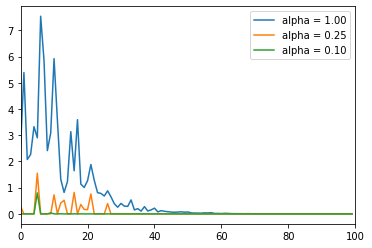

In [24]:
# plot resulting history of objective values
for alpha in alphas:
    plt.plot(objectives[alpha].history, label='alpha = %.2f' % alpha)
plt.legend()
plt.xlim(0, maxiter)
plt.show()

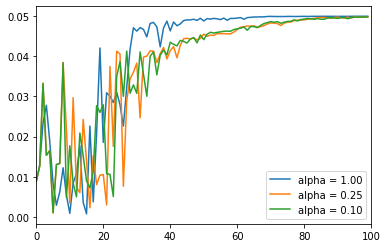

In [25]:
# plot resulting overlap with optimal solution
for alpha in alphas:
    history = objectives[alpha].opt_history  # get history for alpha
    plt.plot(history, label='alpha = %.2f' % alpha)  # plot history for alpha
plt.legend()
plt.xlim(0, maxiter)
plt.show()